In [1]:
import skimage.io
import geopandas as gpd
from skimage import draw
import numpy as np
from skimage.color import rgb2gray 
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool_)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

In [2]:
import glob
annotation_files=sorted(glob.glob('cell_annotations/*.geojson'))

In [4]:
images=[]
annotations=[]
for annotation_file in annotation_files:
    annotation=gpd.read_file(annotation_file)
    image_file=annotation_file.replace('annotations','images').replace('geojson','png')
    image=skimage.io.imread(image_file)
    images.append(image)
    annotations.append(annotation)

In [34]:
from shapely import unary_union, MultiPolygon, Polygon
from scipy.ndimage import label
# build mask based on image shape
masks=[]
nc_ratios=[]
components=[]
for image,annotation_ in zip(images,annotations):
    geometries=annotation_.geometry
    # join union of geometries

    mask=np.zeros(image.shape[:2],dtype=int)
    for geometry in geometries:
        if isinstance(geometry,MultiPolygon): geometry=unary_union([geom.buffer(10) for geom in geometry.geoms])
        if isinstance(geometry, Polygon): geometry=geometry.exterior
        mask+=poly2mask(geometry.coords.xy[1],geometry.coords.xy[0],image.shape[:2]).astype(int)

    mask=(mask>0).astype(int)
    mask+=1 # nucleus mask
    _,n_components = label(mask==2)
    components.append(n_components)
    mask[rgb2gray(image)==1]=0 # background mask
    masks.append(mask)
    nc_ratio=(mask==2).sum()/(mask>0).sum()
    nc_ratios.append(nc_ratio)



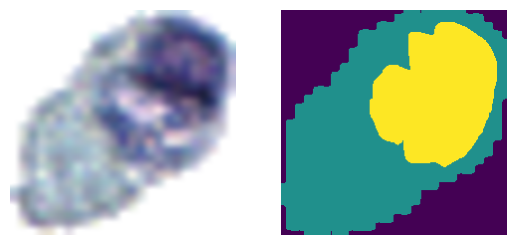

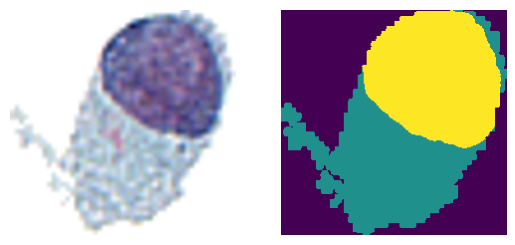

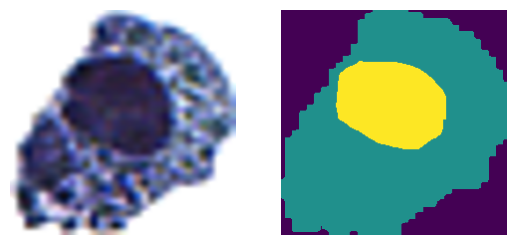

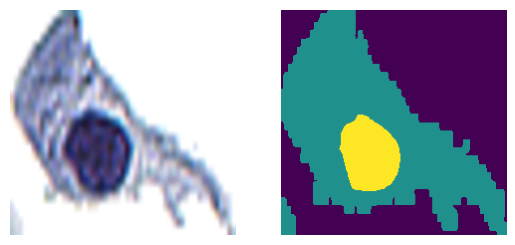

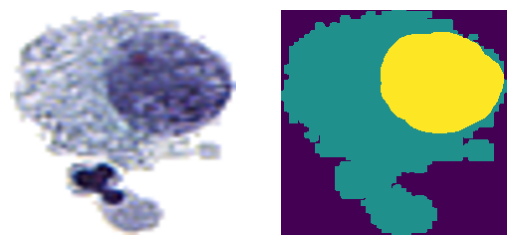

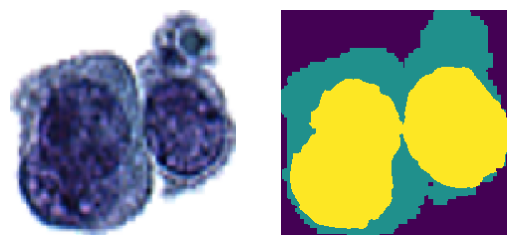

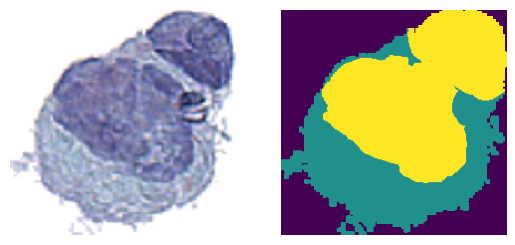

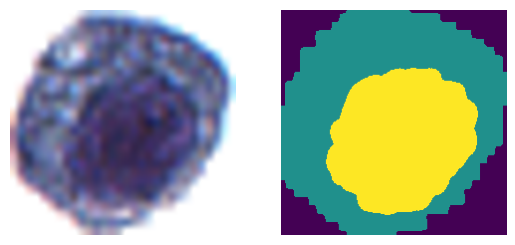

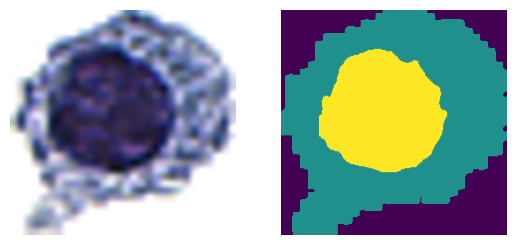

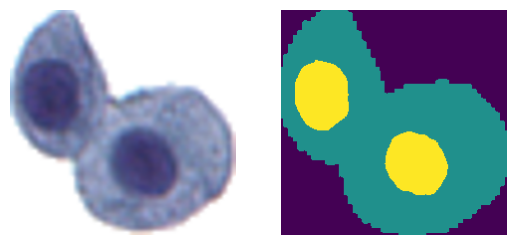

In [33]:
import matplotlib.pyplot as plt
for idx in range(len(images)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(images[idx])
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(masks[idx])
    plt.axis("off")